# Import

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import sys
import glob
import pathlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

!pip install -qqq -U rich
!pip install -qqq ipywidgets
import rich
from rich.progress import track
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
!pip install -qqq torchmetrics
import torchmetrics
!pip install -qqq torchsummary
from torchsummary import summary
import torch.nn.functional as F
from torch import optim
from PIL import Image
from torchvision import transforms as T
from torchvision import models

import warnings
warnings.filterwarnings('ignore')

print(f'Pytorch version: {torch.__version__}')
print(f'Python version: P{sys.version}')


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 238.7/238.7 kB 21.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 43.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.2/519.2 kB 35.1 MB/s eta 0:00:00
Pytorch version: 2.0.1+cu118
Python version: P3.10.11 (main, Apr  5 2023, 14:15:10) [GCC 9.4.0]


In [ ]:
%cd /content/drive/MyDrive/Project AI/Style Transfer

/content/drive/MyDrive/Project AI/Style Transfer


# Prepare

In [ ]:
img_size = 512
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
img_transforms = T.Compose([
    T.Resize((img_size, img_size)),
    T.ToTensor()
])

In [ ]:
def load_img(img_fn):
    global device
    global img_transforms
    image = Image.open(img_fn)
    image = img_transforms(image)
    # to batch
    image = image.unsqueeze(0).to(device, torch.float)
    return image

def to_image(img_tensor):
    image = img_tensor.cpu().clone()
    image = image.squeeze(0)
    image = T.ToPILImage()(image)
    return image

def plot_img(img_tensor, title=None):
    image = to_image(img_tensor) if isinstance(content_img, torch.Tensor) else img_tensor
    plt.imshow(image)
    if title is not None:
        plt.title(title)

def plot_imgs(imgs, cols=2, size=7, title=['content img', 'style img']):
    rows = len(imgs)//cols + 1
    fig = plt.figure(figsize=(cols*size, rows*size))
    for i, img in enumerate(imgs):
        image = to_image(img) if isinstance(img, torch.Tensor) else img
        fig.add_subplot(rows, cols, i+1)
        plt.title(title[i])
        plt.imshow(image)
    plt.show()

# Define Loss Function

In [ ]:
class Normalization(nn.Module):
    def __init__(self):
        super(Normalization, self).__init__()
        self.mean = torch.tensor([0.485, 0.456, 0.406]).view(-1, 1, 1).to(device)
        self.std = torch.tensor([0.229, 0.224, 0.225]).view(-1, 1, 1).to(device)

    def forward(self, image_tensor):
        return (image_tensor - self.mean) / self.std

class ContentLoss(nn.Module):
    def __init__(self, target_feature):
        super(ContentLoss, self).__init__()
        # target_feature is an constant, not variable     
        self.target_feature = target_feature.detach()

    def forward(self, input):
        self.loss = F.l1_loss(input, self.target_feature)
        return input


class StyleLoss(nn.Module):
    def __init__(self, target_feature):
        super().__init__()
        # Detach target since we do not want to use it for gradient computation.
        self._target = self.gram_matrix(target_feature.detach()).detach()

    def gram_matrix(self, input):
        n, c, w, h = input.size()
        features = input.view(n * c, w * h)
        G = torch.mm(features, features.t())
        return G.div(n * c * w * h)

    def forward(self, input):
        G = self.gram_matrix(input)
        self.loss = F.l1_loss(G, self._target)
        return input

def total_variation(tv_weight, img, reduction: str = "sum"):
    if reduction == "sum":
      w_variance = torch.sum(torch.abs(img[:,:,:,:-1] - img[:,:,:,1:]))
      h_variance = torch.sum(torch.abs(img[:,:,:-1,:] - img[:,:,1:,:]))
    elif reduction == "mean":
      w_variance = torch.mean(torch.abs(img[:,:,:,:-1] - img[:,:,:,1:]))
      h_variance = torch.mean(torch.abs(img[:,:,:-1,:] - img[:,:,1:,:]))
    return tv_weight * (h_variance + w_variance)

In [ ]:
def rename_vgg_layers(model):
    """Renames VGG model layers to match those in the paper."""
    block, number = 1, 1
    renamed = nn.Sequential()
    for layer in model.children():
        if isinstance(layer, nn.Conv2d):
            name = f'conv{block}_{number}'
        elif isinstance(layer, nn.ReLU):
            name = f'relu{block}_{number}'
            layer = nn.ReLU(inplace=False)
            number += 1
        elif isinstance(layer, nn.MaxPool2d):
            name = f'pool_{block}'
            # Average pooling was found to generate images of higher quality than
            # max pooling by Gatys et al.
            layer = nn.AvgPool2d(layer.kernel_size, layer.stride)
            block += 1
            number = 1
        else:
            raise RuntimeError(f'Unrecognized layer "{layer.__class__.__name__}""') 
        renamed.add_module(name, layer)

    return renamed

In [ ]:
def get_nst_model_and_losses(model, content_img, style_img, content_layers, style_layers):
    nst_model = nn.Sequential(Normalization())
    content_losses, style_losses, last_layer = [], [], 0
    for i, (name, layer) in enumerate(model.named_children()):
        nst_model.add_module(name, layer)
        if name in content_layers:
            content_loss = ContentLoss(nst_model(content_img))
            nst_model.add_module(f'{name}_ContentLoss', content_loss)
            content_losses.append(content_loss)
            last_layer = i 
        if name in style_layers:
            style_loss = StyleLoss(nst_model(style_img))
            nst_model.add_module(f'{name}_StyleLoss', style_loss)
            style_losses.append(style_loss)
            last_layer = i

    last_layer += 1 + len(content_losses) + len(style_losses)
    nst_model = nst_model[:last_layer+1]
    return nst_model, content_losses, style_losses 


<img src='https://www.researchgate.net/profile/Clifford-Yang/publication/325137356/figure/fig2/AS:670371271413777@1536840374533/llustration-of-the-network-architecture-of-VGG-19-model-conv-means-convolution-FC-means.jpg' />

In [ ]:
cnn_model = models.vgg19(pretrained=True).features.to(device).eval()
cnn_model = rename_vgg_layers(cnn_model)

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:06<00:00, 91.4MB/s]


# Run Style Transfer Model

In [ ]:
def run_style_transfer(
    cnn_model, 
    content_img, 
    style_img, 
    content_layers,
    style_layers,
    input_img=None,
    num_steps=1000, 
    content_weight=1., 
    style_weight=1e9,
    lr=.05,
    tv_weight=1e-5,
    log_steps=50):

    model, content_losses, style_losses = get_nst_model_and_losses(cnn_model, content_img, style_img, 
                                                                   content_layers, 
                                                                   style_layers)
    
    n, c, h, w = content_img.data.size()
    if input_img is None:
        input_img = torch.randn((n, c, h, w), device=device)
        input_img = input_img * .01  # Scale the noise variance down.

    optimizer = optim.Adam([input_img.requires_grad_()], lr=lr)
    
    for step in track(range(num_steps)):
        input_img.data.clamp_(0, 1)
        optimizer.zero_grad()
        content_loss, style_loss = 0, 0
        model(input_img)

        for c_loss in content_losses:
            content_loss += c_loss.loss

        for s_loss in style_losses:
            style_loss += s_loss.loss

        total_loss = content_loss*content_weight + style_loss*style_weight
        total_loss += total_variation(tv_weight, input_img, reduction='mean')
        total_loss.backward()
        optimizer.step()

    return input_img.data.clamp_(0, 1)

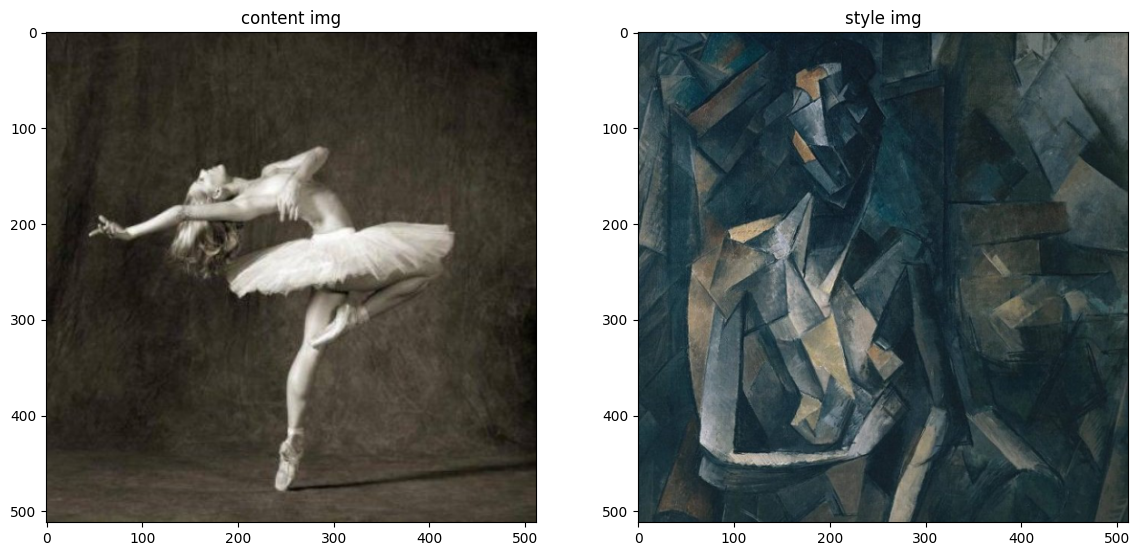

In [ ]:
content_img = load_img('contents/dancing.jpg') 
style_img = load_img('styles/picasso.jpg')
plot_imgs([content_img, style_img])

Output()

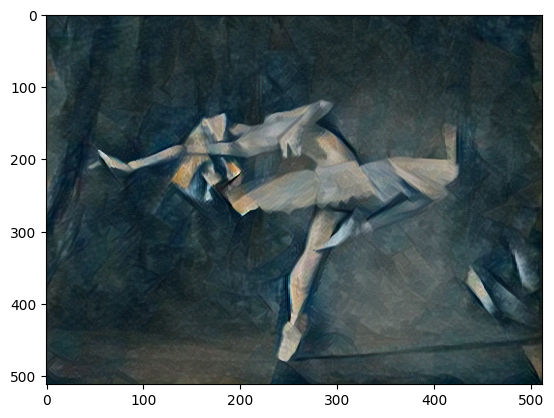

In [ ]:
# input_img = None
input_img = content_img.clone()

content_layers = ['relu3_2']
style_layers = ['relu1_1', 'relu2_1', 'relu3_1', 'relu4_1', 'relu5_1']

output = run_style_transfer( 
    cnn_model, 
    content_img, 
    style_img, 
    content_layers=content_layers,
    style_layers=style_layers,
    input_img=input_img,
    num_steps=2000, 
    content_weight=1, 
    style_weight=2000,
    tv_weight=25,
    log_steps=250)

plt.imshow(output.data.cpu().squeeze(0).permute(1,2,0), aspect='auto')

# Results

In [24]:
from mpl_toolkits.axes_grid1 import ImageGrid

file_contents = glob.glob('contents' + "/*.jpg")
file_styles = glob.glob('styles' + "/*.jpg")
content_layers = ['relu3_2']
style_layers = ['relu1_1', 'relu2_1', 'relu3_1', 'relu4_1', 'relu5_1']

for i in range(len(file_contents)):
    imgs = []
    names = []
    content_img = load_img(file_contents[i]) 

    for j in range(len(file_styles)):
        style_img = load_img(file_styles[j])

        # input_img = None
        input_img = content_img.clone()

        output = run_style_transfer( 
            cnn_model, 
            content_img, 
            style_img, 
            content_layers=content_layers,
            style_layers=style_layers,
            input_img=input_img,
            num_steps=2000, 
            content_weight=1, 
            style_weight=2000,
            tv_weight=25,
            log_steps=250)
        
        imgs.append(output)
        names.append(f'{i}_{j}')

    fig = plt.figure(figsize=(25., 25.))
    grid = ImageGrid(fig, 111, 
                    nrows_ncols=(1, 5),
                    axes_pad=(0.1, 0.3),
                    )

    j = 0
    for ax, im in zip(grid, imgs):
        ax.imshow(im.data.cpu().squeeze(0).permute(1,2,0))
        ax.set_axis_off()
        j += 1
    plt.savefig(f'outputs/image_{i}.png', bbox_inches='tight', pad_inches=0)
    plt.show()

Output hidden; open in https://colab.research.google.com to view.